In [117]:
#import Libraries

In [118]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor    

In [119]:
# Read original patient dataset

In [120]:
originalDataSet = pd.read_csv('Problem2_Data.csv')

In [121]:
#see Data definition

In [122]:
originalDataSet.info()
originalDataSet.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34281 entries, 0 to 34280
Data columns (total 25 columns):
ID        34281 non-null int64
IV        34281 non-null int64
A1        34281 non-null int64
A2        32538 non-null float64
A3        34281 non-null int64
A4        34281 non-null int64
A5        34281 non-null int64
A6        34281 non-null int64
A7        34281 non-null int64
A8        34281 non-null int64
A9        34281 non-null int64
A10       34281 non-null int64
A11       34281 non-null int64
A12       34281 non-null int64
A13       34281 non-null int64
A14       34281 non-null int64
A15       34281 non-null float64
A16       34281 non-null float64
A17       34281 non-null int64
A18       34281 non-null int64
A19       34281 non-null int64
A20       34281 non-null int64
A21       34281 non-null float64
A22       34281 non-null int64
Target    34281 non-null int64
dtypes: float64(4), int64(21)
memory usage: 6.5 MB


,ID,IV,A1,A2,A3,A4,A5,A6,A7,A8,...,A14,A15,A16,A17,A18,A19,A20,A21,A22,Target
0,1443894,2049,44,8.0,11,0,0,0,0,38,...,0,0.52,0.69,0,0,0,1,17.078971,0,0


In [123]:
# see data heat map 

Heat map of patient original data


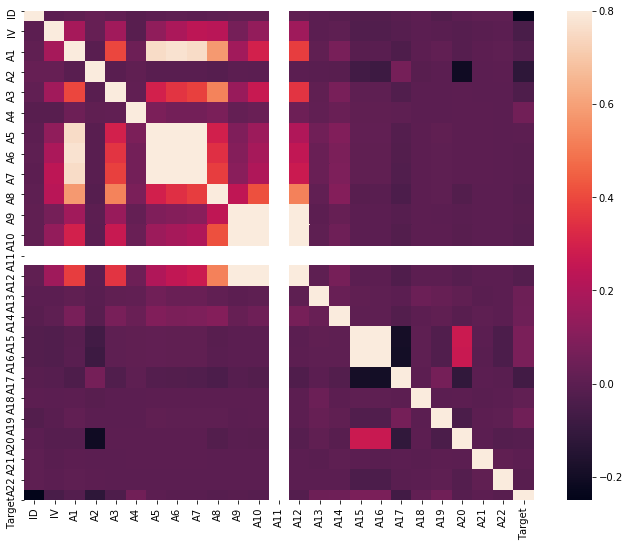

In [126]:
print("Heat map of patient original data")
correlation_matrix = originalDataSet.corr()
fig = plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, vmax=0.8, square=True)
plt.show()

In [127]:
#Perform Data Cleaning 

In [128]:
# find column which hold any null value and replace them with mean of the column
nullcolumnsList = originalDataSet.columns[originalDataSet.isnull().any()]
nullrowsbasedonthecolumnName = originalDataSet[nullcolumnsList].isnull().sum()

# fill null rows with mean of the respective column
nba = originalDataSet.fillna(originalDataSet.mean())

# replace NA with mean of the respective column
nba.replace('NA', originalDataSet.mean())
# make a copy of dataframe and replace -99 with 0 and calculate mean so this mean will use to
#replace with -99 in original dataframe
wba  = nba.copy()
wba[wba == -99] = 0
# Now rpalce dataframe with mean of the respective column from dataset which has zero in palce of -99
nba.replace(-99, wba.mean(),inplace=True)
# delete id column as this was index column of the dataset
nba.drop(['ID'], axis=1, inplace=True)
corr_values_cols = nba.corr(method='pearson').abs()
#general guide for interpreting strength of r (absolute value)
#0 - .2 =  weak, slight
#.2 - .4 = mild/modest
#.4 - .6 = moderate
#.6 - .8 = moderately strong
#.8 - 1.0 = strong

high_corr_var_cols = np.where(corr_values_cols > 0.80)
high_corr_var_cols = [[corr_values_cols.index[x], corr_values_cols.columns[y]] for x, y in zip(*high_corr_var_cols) if
                      x != y and x < y]
uniquecolumn_name_to_be_removed = set()
for i in high_corr_var_cols:
    for j in i:
        uniquecolumn_name_to_be_removed.add(j)

# drop highly corelated columns found in variable uniquecolumn_name_to_be_removed
for x in uniquecolumn_name_to_be_removed:
    nba.drop([x], axis=1, inplace=True)

In [129]:
#Perform Data Normalization

In [130]:
scaler = Normalizer()
nba.loc[:, nba.columns != 'Target'] = scaler.fit_transform(nba.loc[:, nba.columns != 'Target'])

In [131]:
# Remove Data outliers 

In [132]:
def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

FinalDataFrame = calculate_vif_(nba)

dropping 'A11' at index: 6
dropping 'A21' at index: 12
Remaining variables:
Index(['IV', 'A1', 'A2', 'A3', 'A4', 'A8', 'A13', 'A14', 'A17', 'A18', 'A19',
       'A20', 'A22', 'Target'],
      dtype='object')


Heat map of patient data after Data normalization


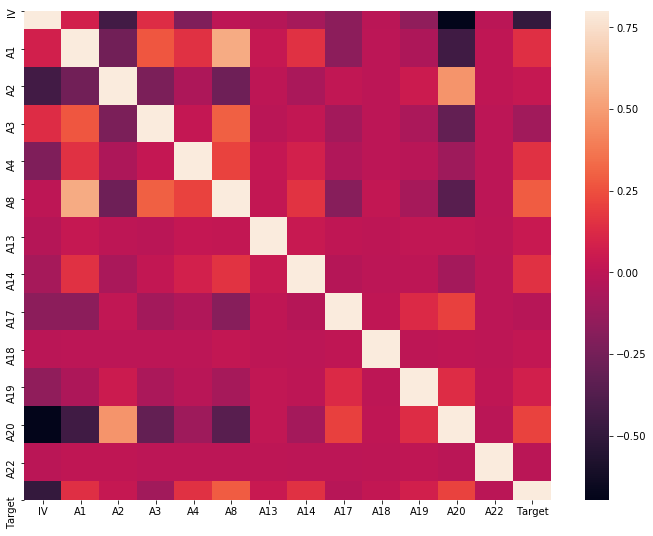

In [133]:
print("Heat map of patient data after Data normalization")
correlation_matrix = FinalDataFrame.corr()
fig = plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, vmax=0.8, square=True)
plt.show()

In [134]:
#Perform PCA analysis and reduce the components 

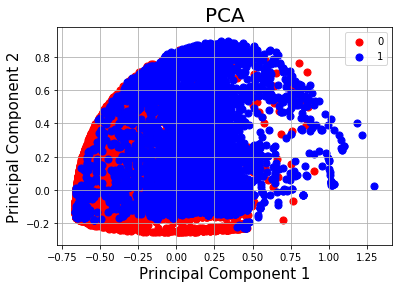

In [135]:

X = FinalDataFrame.drop(['Target'], axis=1)
y = FinalDataFrame['Target']
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X.values)
principalDf = pd.DataFrame(data=principalComponents
                           , columns=['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, y], axis=1)
finalDf.head()
fig, ax = plt.subplots()
ax.set_xlabel('Principal Component 1', fontsize=15)
ax.set_ylabel('Principal Component 2', fontsize=15)
ax.set_title('PCA', fontsize=20)
targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['Target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c=color
               , s=50)
ax.legend(targets)
ax.grid()

In [136]:
#Data splitting

In [137]:
X = finalDf.drop(['Target'], axis=1)
Y = finalDf['Target']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3 )

In [138]:
#Create Logistics Model , train it and test the model 

In [139]:
# Create Model 

logModel = LogisticRegression()

# Tarin Model 

logModel.fit(X_train,y_train)

#Test Model  

predictions = logModel.predict(X_test)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [140]:

#  Evaluate LogisticRegression Model 
print("Classification report LogisticRegression:")
print(classification_report(y_test,predictions))
print("Confusion Matrix LogisticRegression:")
print(confusion_matrix(y_test,predictions))

Classification report LogisticRegression:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      6902
           1       0.76      0.72      0.74      3383

    accuracy                           0.83     10285
   macro avg       0.81      0.80      0.81     10285
weighted avg       0.83      0.83      0.83     10285

Confusion Matrix LogisticRegression:
[[6124  778]
 [ 962 2421]]


In [141]:
#Create KNN (KNeighborsClassifier) Model , train it and test the model 

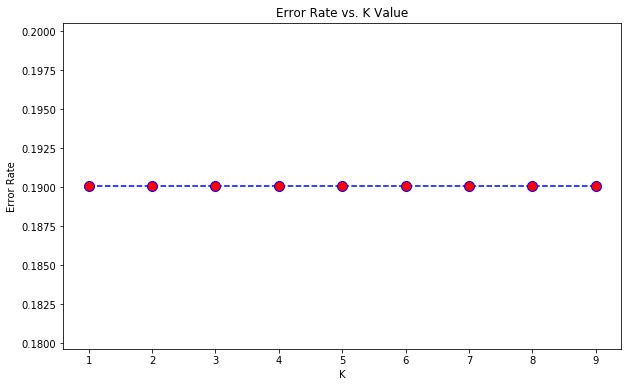

In [142]:
# Create Model 

error_rate = []
for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
plt.figure(figsize=(10,6))
plt.plot(range(1,10),error_rate,color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

knn = KNeighborsClassifier(n_neighbors=1)

# Tarin Model 

knn.fit(X_train,y_train)

# Test Model 

predictions = knn.predict(X_test)


In [143]:

# Evaluate KNN Model 
print("\nNote: From above image:'Error Rate vs. K Value' The Error rate is same accross all k value so we will pick k = 0 as final value")
print(classification_report(y_test,predictions))
print("Confusion Matrix KNN Model:")
print(confusion_matrix(y_test,predictions))


Note: From above image:'Error Rate vs. K Value' The Error rate is same accross all k value so we will pick k = 0 as final value
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      6902
           1       0.70      0.73      0.72      3383

    accuracy                           0.81     10285
   macro avg       0.78      0.79      0.79     10285
weighted avg       0.81      0.81      0.81     10285

Confusion Matrix KNN Model:
[[5874 1028]
 [ 927 2456]]


In [66]:
# Conclusion : LogisticRegression and KNN both model are predicting wheather patient has coronary heart disease or 
# not with 81% to 85% of accuracy

In [144]:
# Areas of Improvement

# 1. we can increase the accuracy up to 90 % by normaliing the data much more if we get the labels of the
# columns as they play a vital role while understanding the data
# as of now we have normalized the data in a standard way 